In [ ]:
# Copyright 2025 Claudio Giovannoni, Carlo Metta, Anna Monreale,
# Salvatore Rinzivillo, Andrea Berti, Sara Colantonio, and
# Francesca Pratesi
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Model Training

In [ ]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import os
import cv2
from google.colab import drive
drive.mount('/content/drive')
import shutil
import matplotlib.pyplot as plt
import sys
from collections import Counter
import re
sys.path.append('/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/')
import model_training_utils
#from crop_data_utils import parse_image_filename

## Create local enviroment dataset

In [ ]:
path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/tabular_final'

train_data_file = os.path.join(path,'X_train.npy')
train_labels_file = os.path.join(path,'y_train.npy')

valid_data_file = os.path.join(path,'X_valid.npy')
valid_labels_file = os.path.join(path,'y_valid.npy')

test_data_file = os.path.join(path,'X_test.npy')
test_labels_file = os.path.join(path,'y_test.npy')

# Load the arrays from the saved files
X_train = np.load(train_data_file)
y_train = np.load(train_labels_file)

X_valid = np.load(valid_data_file)
y_valid = np.load(valid_labels_file)

X_test = np.load(test_data_file)
y_test = np.load(test_labels_file)

print(f'Train shape: {X_train.shape}')
print(f'Validation shape: {X_valid.shape}')
print(f'Test shape: {X_test.shape}')

# standardize labels
y_train = np.reshape(y_train, (-1, 1))
y_valid = np.reshape(y_valid, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

print('\nArrays successfully gathered')

Train shape: (5597, 64, 64, 4)
Validation shape: (700, 64, 64, 4)
Test shape: (698, 64, 64, 4)

Arrays successfully gathered


In [ ]:
# define local folders
env_folder_path = '/content/dataset'

# copy data from external source to local environment
try:
    shutil.copytree(path,env_folder_path)
    print("Local Folders created")

except Exception as ex:
    print(f"{ex}")

Local Folders created


In [ ]:
sets = [X_train, X_valid, X_test]
shapes = [f"Shape of X_{set_name}: {set_data.shape}" for set_name, set_data in zip(["train", "valid", "test"], sets)]
print("\n".join(shapes))

Shape of X_train: (5597, 64, 64, 4)
Shape of X_valid: (700, 64, 64, 4)
Shape of X_test: (698, 64, 64, 4)


In [ ]:
input_shape = (64,64,4)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(buffer_size=len(X_train)).batch(batch_size=128)

valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_data = valid_data.batch(batch_size=1)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.batch(batch_size=1)

train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
import numpy as np
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def balance_dataset(X, y, method='oversample'):
    """
    Balances the dataset by either undersampling or oversampling.

    Parameters:
    X (numpy.ndarray): Feature matrix.
    y (numpy.ndarray): Target array.
    method (str): Method to balance dataset ('undersample' or 'oversample').

    Returns:
    X_resampled (numpy.ndarray): Resampled feature matrix.
    y_resampled (numpy.ndarray): Resampled target array.
    """

    # Store the original sample dimension for later use
    sample_dimension = X.shape[1:]

    # Flatten X for resampling
    X = X.reshape(X.shape[0], -1)

    unique, counts = np.unique(y, return_counts=True)
    print("Original dataset shape:", dict(zip(unique, counts)))

    if method == 'oversample':
        resampler = RandomOverSampler(random_state=0)
    elif method == 'undersample':
        resampler = RandomUnderSampler(random_state=0)
    else:
        raise ValueError("Method must be 'oversample' or 'undersample'")

    X_resampled, y_resampled = resampler.fit_resample(X, y)

    # Reshape X_resampled to have the original sample dimensions
    X_resampled = X_resampled.reshape(-1, *sample_dimension)

    unique_resampled, counts_resampled = np.unique(y_resampled, return_counts=True)
    print("Resampled dataset shape:", dict(zip(unique_resampled, counts_resampled)))

    return X_resampled, y_resampled

In [ ]:
X_train, y_train = balance_dataset(X_train, y_train, method='oversample')

Original dataset shape: {0: 1552, 1: 1552}
Resampled dataset shape: {0: 1552, 1: 1552}


# Model Building

In [ ]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from keras.models import Model

def resnet(input_shape=input_shape, num_classes=1):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = True

    # custom classification layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=outputs)

    #alpha = 1e-5
    #for layer in model.layers:
        #if hasattr(layer, "kernel_regularizer"):
            #layer.kernel_regularizer = tf.keras.regularizers.l2(alpha)

    return model

In [ ]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from keras.regularizers import l2
from keras.models import Model

def residual_block(x, filters, stride=1, first_block=False):
    weight_decay=1e-4

    # Shortcut connection
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)

    # Adjusting dimensions of the shortcut to match the main path
    if first_block:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def resnet_v2_20(input_shape=input_shape, num_classes=1):
    inputs = Input(shape=input_shape)
    weight_decay=1e-4

    # Initial convolution layer
    x = Conv2D(16, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Stacking residual blocks
    num_blocks = [3, 3, 3]
    filters = [16, 32, 64]

    for stage in range(3):
        for block in range(num_blocks[stage]):
            stride = 1
            if stage > 0 and block == 0:
                stride = 2

            x = residual_block(x, filters[stage], stride=stride, first_block=(block == 0))

    # Global average pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers for classification
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, x, name='resnet_v2_20')
    return model

In [ ]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, LeakyReLU
from keras.models import Model

def cnn(input_shape=input_shape, num_classes=1):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2))(x)

    # Global average pooling and dense layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

In [ ]:
# @title
# Custom Weighted Binary Cross-Entropy Loss function
from keras import backend as K
from keras.backend import clip, log, mean

def wbce(weight1, weight0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')
        y_true = K.clip(y_true, K.epsilon(), 1 - K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        logloss = -(y_true * K.log(y_pred) * weight1 + (1 - y_true) * K.log(1 - y_pred) * weight0)
        return K.mean(logloss, axis=-1)
    return loss

In [ ]:
# @title

def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    elif epoch % 50 == 0:
        lr *= 0.1
        return lr
    else:
        return lr

In [ ]:
def scheduler(epoch, lr):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 160:
        lr *= 0.5e-3
    elif epoch > 120:
        lr *= 1e-3
    elif epoch > 80:
        lr *= 1e-2
    elif epoch > 40:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
from keras.optimizers import Adam, SGD
from keras.losses import binary_crossentropy

num_classes = 1
model = cnn()
optimizer = SGD(learning_rate=1e-5, momentum = 0.9)
loss = model_training_utils.wbce(7,3)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy', 'AUC'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        2368      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856 

In [ ]:
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

## Model Fitting

In [ ]:
# Define callbacks
from keras.callbacks import LearningRateScheduler

checkpoint_path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/models/best_model_auc.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_best_only=True,
                                                monitor='val_auc',
                                                mode='max')
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(model_training_utils.scheduler)

In [ ]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    callbacks=[lr_scheduler,checkpoint],
                    epochs=200)

test_loss, test_accuracy, auc = model.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test AUC:", auc)

Epoch 1/200
25/25 [==============================] - ETA: 0s - loss: 3.9156 - accuracy: 0.5190 - auc: 0.5084

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 32s 918ms/step - loss: 3.9156 - accuracy: 0.5190 - auc: 0.5084 - val_loss: 2.9030 - val_accuracy: 0.7100 - val_auc: 0.5000 - lr: 1.0000e-05
Epoch 2/200
25/25 [==============================] - 3s 143ms/step - loss: 3.8361 - accuracy: 0.5100 - auc: 0.5111 - val_loss: 2.8960 - val_accuracy: 0.7100 - val_auc: 0.5050 - lr: 1.0000e-05
Epoch 3/200
25/25 [==============================] - 3s 111ms/step - loss: 3.7764 - accuracy: 0.5093 - auc: 0.5100 - val_loss: 2.8865 - val_accuracy: 0.7100 - val_auc: 0.5000 - lr: 1.0000e-05
Epoch 4/200
25/25 [==============================] - 4s 144ms/step - loss: 3.7870 - accuracy: 0.5029 - auc: 0.4972 - val_loss: 2.8827 - val_accuracy: 0.7100 - val_auc: 0.3946 - lr: 1.0000e-05
Epoch 5/200
25/25 [==============================] - 4s 145ms/step - loss: 3.7594 - accuracy: 0.5045 - auc: 0.5079 - val_loss: 2.8895 - val_accuracy: 0.2900 - val_auc: 0.5064 - lr: 1.0000e-05
Epoch 6/200
21/25 [========================>.....] 

KeyboardInterrupt: 

# Model Evaluation

In [ ]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/models/best_model_auc.h5'
model = load_model(model_path, compile=False)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

data_list = [(valid_data, y_valid), (test_data, y_test)]
for data in data_list:
    # Predict on the dataset using the model
    predictions = model.predict(data[0])
    predicted_labels = np.round(predictions).astype(int)
    # Generate the classification report
    report = classification_report(data[1],
                                    predicted_labels,
                                    target_names=['Class 0', 'Class 1'])
    if data == data_list[0]:
        print('\nValidation\n', report)
    else:
        print('\nTest\n', report)

700/700 [==============================] - 8s 11ms/step
Validation
               precision    recall  f1-score   support

     Class 0       0.82      0.64      0.72       497
     Class 1       0.42      0.66      0.51       203

    accuracy                           0.64       700
   macro avg       0.62      0.65      0.62       700
weighted avg       0.70      0.64      0.66       700

703/703 [==============================] - 6s 9ms/step
Test
               precision    recall  f1-score   support

     Class 0       0.83      0.56      0.67       502
     Class 1       0.40      0.71      0.51       201

    accuracy                           0.61       703
   macro avg       0.61      0.64      0.59       703
weighted avg       0.71      0.61      0.62       703



In [ ]:
model_training_utils.plot_roc_auc(test_data,valid_data)

700/700 [==============================] - 5s 7ms/step


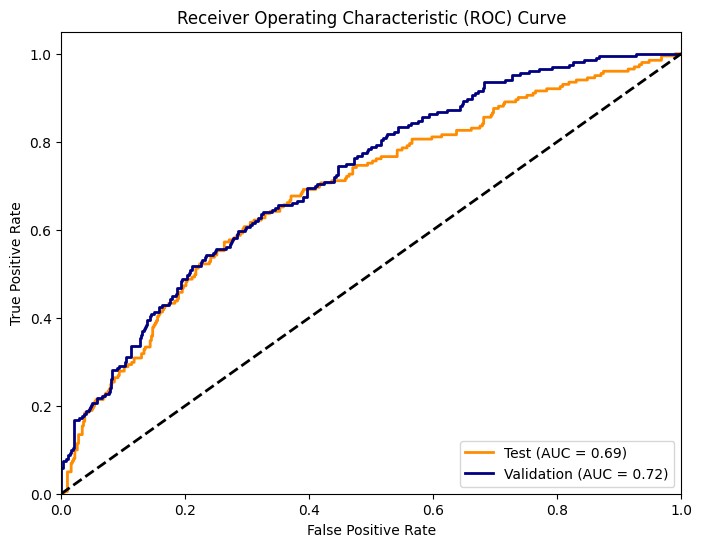

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test and validation sets
predicted_probs_te = model.predict(test_data)
predicted_probs_val = model.predict(valid_data)

# Calculate ROC curve and AUC for test set
fpr_te, tpr_te, thresholds_te = roc_curve(y_test, predicted_probs_te)
roc_auc_te = auc(fpr_te, tpr_te)

# Calculate ROC curve and AUC for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_valid, predicted_probs_val)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curve for both test and validation sets
plt.figure(figsize=(8, 6))

plt.plot(fpr_te, tpr_te, color='darkorange', lw=2, label=f'Test (AUC = {roc_auc_te:.2f})')
plt.plot(fpr_val, tpr_val, color='navy', lw=2, label=f'Validation (AUC = {roc_auc_val:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

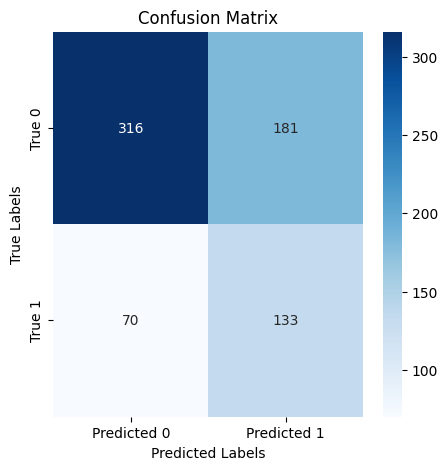

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
predicted_labels = (predicted_probs > 0.5).astype(int)  # Assuming binary classification with a threshold of 0.5

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_valid, predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

NameError: ignored

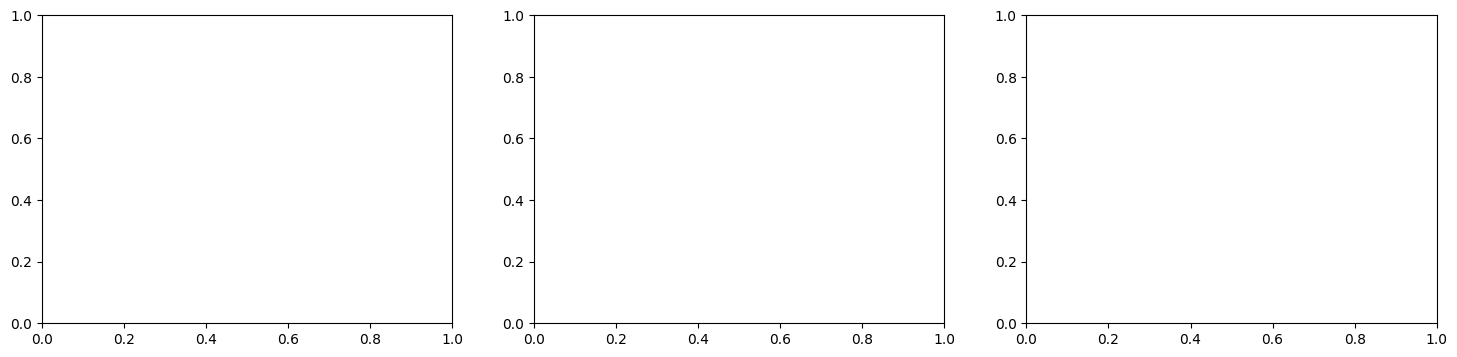

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

axs[0].plot(history.history['loss'], label='Train')
axs[0].plot(history.history['val_loss'], label='Validation')
axs[0].set_ylabel('Categorical Cross Entropy Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='best')

axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='best')

axs[2].plot(history.history['auc'], label='Train AUC')
axs[2].plot(history.history['val_auc'], label='Validation AUC')
axs[2].set_ylabel('AUC Score')
axs[2].set_xlabel('Epoch')
axs[2].legend(loc='best')

plt.show()